# Sudoku Solver (v3)

Close to final form.

Objectives:

1. Assess effectiveness and performance against different test cases
 1. Back tracking
 2. Back tracking + constraint propogation
 3. Deductive logic
 4. Solution X or Dancing Links?
3. Learn some more Pandas + Matplotlib (draw some pretty graphs)
4. ~~Assess performance against other implementations~~


## Supporting Packages

**TODO**: Brief description of [sudoku](sudoku.py) and [puzzlegrid](puzzlegrid.py) libraries.


In [1]:
import sudoku as su
import puzzlegrid as pg

**TODO**: Brief description of why we need the following

In [2]:
import copy
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display, clear_output

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 6]
pd.set_option('precision', 4)


## Help functions

**TODO:** Print puzzles descriptions.


In [3]:
def print_puzzle(puzzle, **args):
    display(HTML(puzzle.as_html(**args)))

def print_2_puzzles(puz1, puz2, **args):
    display(HTML('<table><tr><td>' + puz1.as_html(**args) + '</td><td>' + puz2.as_html() + '</td></tr></table>'))

def update_progress(label, current, total, time_so_far, test_case):
    clear_output(wait=True)
    display(HTML(f'<progress style="width: 100%" max={total} value={current}>{current} out of {total}</progress>'))
    if test_case:
        display(HTML(f"<p>Working on {label}: <i>{test_case['label']}</i>, total time so far {time_so_far:.2f} seconds</p>"))
    else:
        display(HTML(f"<p>Completed in {time_so_far:.2f} seconds</p>"))
    return

## Example class usage

Create a puzzle in `SudokuPuzzle` then use separate class `SudokuSolver`. Separation FTW.


In [4]:
puzzle = su.SudokuPuzzle(starting_grid=su.SAMPLE_PUZZLES[0]['puzzle'])
original = copy.deepcopy(puzzle)
solver = su.SudokuSolver()
solver.solve(puzzle)
print_2_puzzles(original, puzzle, show_possibilities=2)

8,9,,4,"{1, 7}","{2, 7}",,5,6
1,4,,3,5,,{7},9,"{2, 7}"
,,,,,,8,"{2, 3}",
9,,,,,,2,,"{1, 7}"
,8,,9,6,5,,4,"{1, 7}"
,"{6, 7}",1,,,,,,5
,,8,"{5, 7}",,,,"{2, 6}",
"{5, 6}",3,,{5},2,1,,7,8
4,2,,,,6,"{9, 5}",1,3
8,9,3,4,7,2,1,5,6
1,4,6,3,5,8,7,9,2


In [5]:
puzzle.init_puzzle(su.SAMPLE_PUZZLES[0]['puzzle'])
solver.solve_only_squares(puzzle)
print_2_puzzles(original, puzzle, show_possibilities=2)

8,9,,4,"{1, 7}","{2, 7}",,5,6
1,4,,3,5,,{7},9,"{2, 7}"
,,,,,,8,"{2, 3}",
9,,,,,,2,,"{1, 7}"
,8,,9,6,5,,4,"{1, 7}"
,"{6, 7}",1,,,,,,5
,,8,"{5, 7}",,,,"{2, 6}",
"{5, 6}",3,,{5},2,1,,7,8
4,2,,,,6,"{9, 5}",1,3
8,9,3,4,7,2,1,5,6
1,4,6,3,5,8,7,9,2


In [7]:
print(solver.max_depth, solver.backtrack_count)

49 204


In [8]:
p2 = su.SudokuPuzzle(starting_grid='1..7...4....1..589...2.5.3797....3.....6.........3.8913........65...4....29..6..4')

p2.set(2, 6, 1)
p2.set(1, 5, 3)
p2.set(8, 6, 7)
p2.set(8, 0, 8)
p2.set(2, 0, 4)
p2.set(1, 1, 6)

print_puzzle(p2, show_possibilities=2)

1,,,7,,"{8, 9}","{2, 6}",4,"{2, 6}"
"{2, 7}",6,"{2, 7}",1,{4},3,5,8,9
4,"{8, 9}",{8},2,,5,1,3,7
9,7,,,,,3,,
"{2, 5}",,,6,,,"{2, 4}",,"{2, 5}"
"{2, 5}",{4},,"{4, 5}",3,"{2, 7}",8,9,1
3,"{1, 4}",,,,,,,
6,5,"{1, 7}",,,4,"{9, 2}","{1, 2}",
8,2,9,"{3, 5}","{1, 5}",6,7,"{1, 5}",4


# Sudoku Solution Strategies

Running some timing tests. Using 2017 Macbook Pro (2.3 GHz Intel Core i5).

## Backtracking

**TODO:** Explanation of algorithm.

### Evaluating Backtracking

In test code below, limiting `include_levels` to `Kids`, `Easy`, and `Moderate` will complete the testing in ~1 second. On the other hand:

* `Hard` extends the running time to ~9 seconds.
* `Diabolical` takes ~5 minutes.
* `Pathalogical` takes ~36 minutes.

The time is due to the poor performance of the naive "backtracking" algorithm on some (but not all) puzzles. We're also solving each puzzle `NUM_SAMPLES` times (3 by default). We then average out the running times.



In [6]:
include_levels = ['Kids', 'Easy', 'Moderate'] # ['Hard', 'Diabolical', 'Pathalogical']
test_cases = [x for x in su.SAMPLE_PUZZLES if x['level'] in include_levels]

NUM_SAMPLES=5

Using the `PuzzleTester` class. Takes test cases and then runs Sudoku solvers against each one. The list `su.SOLVERS` contains the list of solving algorithms that the solver class supports. We'll start with `backtracking`.

In [7]:
pt = pg.PuzzleTester(puzzle_class=su.SudokuPuzzle, test_samples=NUM_SAMPLES)
pt.add_testcases(test_cases)

method = 'backtracking'
solver = su.SudokuSolver(method=method)
n = pt.run_tests(solver, method, callback=update_progress)


Can see some results below. Sorted by time taken (longest first). Plain backtracking is always slower, and on some puzzles it's a huge difference. 

In [8]:
df = pd.DataFrame(pt.get_test_results())
df.sort_values(by=method, ascending=False).head(n=5)


,label,level,starting_clues,backtracking
1,SMH 2,Easy,24,0.2050
4,SMH 3,Moderate,26,0.0876
3,Rico Alan Heart,Easy,22,0.0809
2,KTH 1,Easy,30,0.0183
0,SMH 1,Kids,31,0.0044


## Solving Harder Puzzles

Add more test cases from [Peter Norvig](https://norvig.com/sudoku.html).

If the test results file exists we'll use the results from earlier. Otherwise, this will re-run all the tests which took ~3.5 hours on my 2017 Macbook Pro (2.3 GHz Intel Core i5).


In [9]:
import os.path

TEST_RESULTS = "sudoku_test_results.pkl"
if os.path.isfile(TEST_RESULTS):
    df = pd.read_pickle(TEST_RESULTS)
else:
    # pt.add_testcases([x for x in su.SAMPLE_PUZZLES if x['level'] not in include_levels])
    pt.add_testcases(pg.from_file("data/hardest.txt", level="Hard"))
    pt.add_testcases(pg.from_file("data/top95.txt", level="Diabolical"))
    for m in su.SOLVERS:
        solver = su.SudokuSolver(method=m)
        pt.run_tests(solver, m, callback=update_progress)
    df = pd.DataFrame(pt.get_test_results())
    df.to_pickle(TEST_RESULTS)


In [10]:
df.describe()


,starting_clues,backtracking,constraintpropogation
count,114.0000,114.0000,114.0000
mean,21.2632,44.0623,0.6161
std,3.4744,155.3830,1.8542
min,17.0000,0.0026,0.0014
25%,17.0000,0.2937,0.0215
50%,22.0000,2.0871,0.0668
75%,24.0000,11.8639,0.2124
max,31.0000,1173.6804,12.7283


So, yeah. Backtracking alone is appalling. Look it.

* 75% of the test cases are solved in ~0.2 seconds with the constraint propogation solution, but we need ~12 seconds using backtrackng alone.
* Mean time is terrible for backtracking alone (~35 seconds). 

You can see the variability better with the following plot.

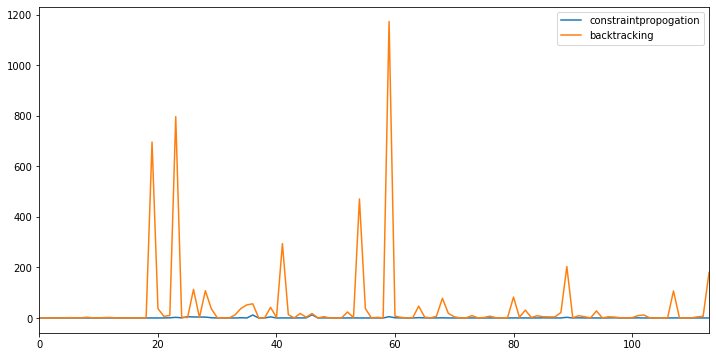

In [11]:
axs = df[su.SOLVERS].plot()


So, at this point, going to stop testing with backtracking alone. But there are a few puzzles that seem to be particularly difficult for the constraint propogation solution, so let's look at those.

## Constraint Propogation

**TODO**: Explanation of CP.

### Evaluating CP

The majority of the test puzzles are solved in < ~ 0.2 seconds, however there are some that take longer, up to a maxiumum of 12 seconds.


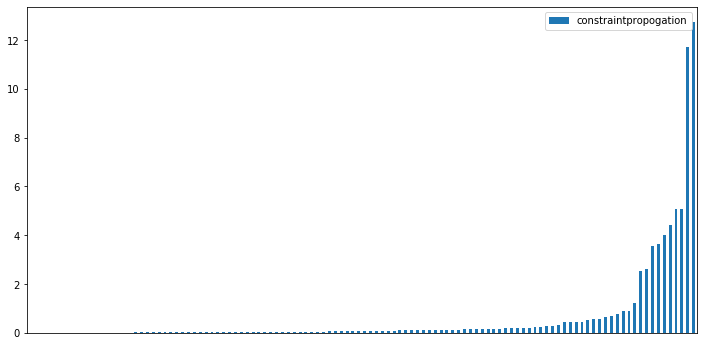

In [12]:
method = 'constraintpropogation'
axs = df.sort_values(by=method)[[method]].plot(kind='bar')
axs.xaxis.label.set_visible(False)
axs.xaxis.set_ticks([])
plt.show()

Let's take a look at those puzzles that take so much longer to solve and see if we can work out what's happening there.

In [13]:
def highlight_where_backtracking_faster(s):
    if s.constraintpropogation > s.backtracking:
        return ['background-color: yellow; color: black'] * 5
    elif s.constraintpropogation < 1.0:
        return ['background-color: lightgreen; color: black'] * 5
    else:
        return ['background-color: black; color: white'] * 5

ndf = df.sort_values(by=method, ascending=False).head(n=12)
ndf.style.apply(highlight_where_backtracking_faster, axis=1).bar(subset=[method], color='orange').format({method: "{:.3f}", 'backtracking': '{:.3f}'})


,label,level,starting_clues,backtracking,constraintpropogation
46,data/top95.txt:28,Diabolical,17,17.600,12.728
36,data/top95.txt:18,Diabolical,17,56.110,11.702
25,data/top95.txt:7,Diabolical,17,1.689,5.066
59,data/top95.txt:41,Diabolical,17,1173.680,5.052
39,data/top95.txt:21,Diabolical,17,42.158,4.399
26,data/top95.txt:8,Diabolical,17,113.170,4.012
27,data/top95.txt:9,Diabolical,17,1.691,3.630
28,data/top95.txt:10,Diabolical,17,107.888,3.551
89,data/top95.txt:71,Diabolical,17,203.557,2.622
23,data/top95.txt:5,Diabolical,17,796.919,2.526


Interesting points:

* Puzzles 7 and 9 (highlighted yellow) actually take longer to solve with the constraint propogation solution than simple backtracking
* Puzzles 21 and 46 look like good candidates for looking at closer, because the backtracking time isn't so long that we can't wait for profiler output if we want to compare profiles
* Puzzle 42 looks like a good place to start though: < ~1 second (highlighted green)

So let's look at Puzzle 42 (answer to the Ultimate Question?), using the built in Jupyet profiler tools. First though, a quick check that the total time matches up. According to original testing performance, this should take ~8 microseconds (ms).


In [14]:
puzzle42 = '......8.16..2........7.5......6...2..1....3...8.......2......7..3..8....5...4....'
puzzle.init_puzzle(puzzle42)
solver = su.SudokuSolver(method=method)
%time solver.solve(puzzle)

CPU times: user 800 ms, sys: 7.03 ms, total: 807 ms
Wall time: 842 ms


True

That looks OK. So reset the puzzle and profile below. The profiler itself adds some overhead so this takes slightly longer (~1.2 seconds).

In [15]:
puzzle.init_puzzle(puzzle42)
s = su.SudokuSolver(method=method)
%prun s.solve(puzzle)

         2059320 function calls (2030330 primitive calls) in 1.189 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   398932    0.370    0.000    0.666    0.000 sudoku.py:96(get_allowed_values)
    57980    0.245    0.000    0.844    0.000 puzzlegrid.py:256(next_best_empty_cell)
   398932    0.193    0.000    0.193    0.000 puzzlegrid.py:293(get_allowed_values)
   456848    0.118    0.000    0.118    0.000 sudoku.py:48(box_xy_to_num)
  28991/1    0.074    0.000    1.189    1.189 sudoku.py:211(solve_constraintpropogation)
    28990    0.037    0.000    0.102    0.000 puzzlegrid.py:173(set)
    28926    0.031    0.000    0.072    0.000 sudoku.py:69(clear)
    28990    0.030    0.000    0.143    0.000 sudoku.py:56(set)
    28926    0.025    0.000    0.031    0.000 puzzlegrid.py:202(clear)
   341006    0.023    0.000    0.023    0.000 {built-in method builtins.len}
    28990    0.015    0.000    0.059    0.000 puzzlegrid.py:305

Notes:

* 399K calls to `get_allowed_values`. The first entry is in [sudoku.py](sudoku.py#line_88), which gets the allowed values for the box, then calls the same method in the [parent class](puzzlegrid.py#line_321) to return the intersection of allowed cells in that row, column and box.
* Recurses into `solve_constraintpropogation` 29K times.

Compare the performance of #42 to #46. Expect #46 to take ~2.5 seconds.

In [16]:
puzzle46 = '.834.........7..5...........4.1.8..........27...3.....2.6.5....5.....8........1..'
puzzle.init_puzzle(puzzle46)
solver = su.SudokuSolver(method=method)
%time solver.solve(puzzle)

CPU times: user 247 ms, sys: 3.37 ms, total: 250 ms
Wall time: 256 ms


True

OK, this is weird. That was supposed to take ~2.5 seconds and instead finished in ~0.3 seconds. Let's run it again...and again. And this time we'll output some of the stats collected by the solver itself:

* Max Depth: The deepest stack-depth the recursion reached
* Backtracks: The number of "mistakes" made by the algorithm that resulted in it backtracking to a prior state


In [17]:
puzzle = su.SudokuPuzzle()
solver = su.SudokuSolver(method=method)
for i in range(5):
    print(f"RUN {i}")
    puzzle.init_puzzle(starting_grid=puzzle46)
    assert(not puzzle.is_solved())
    %time solver.solve(puzzle)
    print(f"Max Depth={solver.max_depth}; Backtracks={solver.backtrack_count}\n")

RUN 0
CPU times: user 2.65 s, sys: 18.2 ms, total: 2.66 s
Wall time: 2.73 s
Max Depth=63; Backtracks=105917

RUN 1
CPU times: user 2.55 s, sys: 7.63 ms, total: 2.56 s
Wall time: 2.59 s
Max Depth=63; Backtracks=105917

RUN 2
CPU times: user 226 ms, sys: 765 µs, total: 227 ms
Wall time: 229 ms
Max Depth=63; Backtracks=8766

RUN 3
CPU times: user 252 ms, sys: 1.97 ms, total: 254 ms
Wall time: 260 ms
Max Depth=63; Backtracks=8766

RUN 4
CPU times: user 224 ms, sys: 747 µs, total: 225 ms
Wall time: 225 ms
Max Depth=63; Backtracks=8766



In testing, the first two usually take ~2.5 seconds, and the last 3 take ~220 ms. Even though it's exactly the same puzzle being solved by exactly the same algorithm.

Difference is caused by the return order of the set of allowed values. Since the values are returned in a set, the order of the set members is not guaranteed to be consistent. When the order is slightly different, then the backtracking can take dramatically different search paths, with consequent impacts on run time. You can see this in the `Backtracks` reported (105K vs 88K).

In this specific case, one of the cells has allowed values (1, 9). If "1" is chosen then the solution takes 2.5 seconds to find. However if the "9" is chosen, then the search takes ~220 ms. 

If I modify the algorithm to always sort the allowed values then the performance time is always consistent. Otherwise there's a certain amount of randmomness to it.

The other change is to recreate the `puzzle` instance each time. When I do that, the performance remains consistent, because the set order remains consistent. Not sure why that is.


# Next Steps

Still to do:

* Not sure if the change in set ordering happens when running tests in `PuzzleTester` -- should check and see if that impacts results (I get an average but what's the stddev?)
* Could force the set ordering to be deterministic and test with different preferred sort orders. Expect to find the same range of performance times, even as times for individual puzzles might vary.

On that first point: I changed the code so that I get the expected behaviour. The method `run_single_test` was creating a new `SudokuPuzzle` instance each and every time it was called. I changed it to re-use the same instance and can now observe the variation. Not sure if that's really desireable or not.


In [18]:
newpt = pg.PuzzleTester(puzzle_class=su.SudokuPuzzle, test_samples=10)
newcases = [x for x in pg.from_file("data/top95.txt", level="Diabolical") if x['label'] == 'data/top95.txt:46']
newpt.add_testcases(newcases)
newpt.num_testcases()

In [18]:
method = 'constraintpropogation'
solver = su.SudokuSolver(method=method)
newpt.run_tests(solver, method, callback=update_progress)
newdf = pd.DataFrame(newpt.get_test_results())
newdf

,label,level,starting_clues,constraintpropogation
0,data/top95.txt:46,Diabolical,17,0.7591


# Just for Fun: Cheating

Occurred to me that the way I've designed the puzzle and solver classes opens the way to having a "cheating" solver. Basically a solver that over-writes the puzzle with a pre-programmed sequence of numbers that obey the rules but do not match the original puzzle clues.

So just for fun let's see how easy that is to do and how I could improve the puzzle class to detect and block attempts to "cheat".


In [19]:
class CheatingSolver(pg.ConstraintSolver):
    def solve(self, puzzle):
        """Easiest way to cheat would be to trick the is_solved() method on the puzzle to always returning True"""
        puzzle._num_empty_cells = 0
        return True

puzzle = su.SudokuPuzzle(starting_grid=su.SAMPLE_PUZZLES[0]['puzzle'])
solver = CheatingSolver()
solver.solve(puzzle)
puzzle.is_solved()

True

Gah. That was *too* easy. So maybe instead we should at least make sure that `is_solved()` does a cell-by-cell check to see that all values are really filled in.

In [20]:
class AntiCheatSudoku(su.SudokuPuzzle):
    def is_solved(self):
        if self.is_puzzle_valid():
            for i in range(self.max_value()):
                for j in range(self.max_value()):
                    if self.is_empty(i, j):
                        return False
            return True
        else:
            return False
    
puzzle = AntiCheatSudoku(starting_grid=su.SAMPLE_PUZZLES[0]['puzzle'])
solver = CheatingSolver()
solver.solve(puzzle)

True

In [21]:
puzzle.is_solved()

False

A little better -- the puzzle instance at least knows it is not solved, even though the "solver" reported that it was. So all we'd need to do now is make sure our test harness noticed the discrepency and threw away such results.

In [26]:
pt._puzzle_class=AntiCheatSudoku
method = 'cheating'
solver = CheatingSolver()
pt.run_tests(solver, method)

5

In [27]:
df = pd.DataFrame(pt.get_test_results())
df

,label,level,starting_clues,backtracking,cheating
0,SMH 1,Kids,31,0.0044,None
1,SMH 2,Easy,24,0.2050,None
2,KTH 1,Easy,30,0.0183,None
3,Rico Alan Heart,Easy,22,0.0809,None
4,SMH 3,Moderate,26,0.0876,None


So I had to change `PuzzleTester` class to check the return value of `run_single_test` (which returns the value of `puzzle.is_solved()`) so at least if the puzzle asserts that it is NOT solved then no result is recorded for the solver.

## Cheating Attempt #2

So since our really simple cheater no longer works I guess we'll need a more sophisticated version. We could just fill in the blank cells with "1" (or any other value) but then the `is_puzzle_valid` check would fail, at which point we may as well solve it properly. Let's just verify that that's true...


In [28]:
class CheatingSolver(pg.ConstraintSolver):
    def solve(self, puzzle):
        """Write some random value into empty cells"""
        for i in range(puzzle.max_value()):
            for j in range(puzzle.max_value()):
                if puzzle.is_empty(i, j):
                    # can't use set() because it checks validity!
                    puzzle._grid[i][j] = 1
        puzzle._num_empty_cells = 0
        return True

In [29]:
puzzle = AntiCheatSudoku(starting_grid=su.SAMPLE_PUZZLES[0]['puzzle'])
solver = CheatingSolver()
solver.solve(puzzle)
puzzle.is_solved()

False

Correct! And that's because the puzzle isn't valid, right?

In [30]:
puzzle.is_puzzle_valid()

False

Excellent! 

So maybe what our cheat needs to do is overwrite *all* cells in a rule-abiding way. We won't be actually solving the original puzzle. Basically, we're just writing a "pre-solved" puzzle over the top.

In [31]:
class CheatingSolver(pg.ConstraintSolver):
    def solve(self, puzzle):
        """Write a pre-solved puzzle in over the top of the provided one"""
        starting_values = [0, 3, 6, 1, 4, 7, 2, 5, 8]
        max_value = puzzle.max_value()
        puzzle.clear_all()
        for i in range(max_value):
            for j in range(max_value):
                #print(i, j, (starting_values[i] + j) % max_value + 1)
                puzzle.set(i, j, (starting_values[i] + j) % max_value + 1)
        return True

In [32]:
puzzle = AntiCheatSudoku(starting_grid=su.SAMPLE_PUZZLES[0]['puzzle'])
solver = CheatingSolver()
solver.solve(puzzle)
puzzle.is_solved()

True

The whole point of this is to be faster than a real solver, so let's test performance.

In [34]:
method = 'overwrite'
pt.run_tests(solver, method)
df = pd.DataFrame(pt.get_test_results())
df

,label,level,starting_clues,backtracking,cheating,overwrite
0,SMH 1,Kids,31,0.0044,None,0.0008
1,SMH 2,Easy,24,0.2050,None,0.0008
2,KTH 1,Easy,30,0.0183,None,0.0007
3,Rico Alan Heart,Easy,22,0.0809,None,0.0006
4,SMH 3,Moderate,26,0.0876,None,0.0010


## Catching Cheat #2

To prevent the new cheat we basically need to compare the puzzle with a copy of the original. That way we can detect that the starting clues have been over written.

We can't do this in the `SudokuPuzzle` itself. Python doesn't really have `private` attributes, [just a naming convention](https://docs.python.org/3/tutorial/classes.html#tut-private) that signals "hey, you're not supposed to muck around with this", but we've already seen that we can pretty much ignore that and modify the class's internals. And since we're trying to guard against cheating we can assume an attacker will happily ignore convention.

If we assume that the caller (test harness) can be trusted then we can let the caller verify that the original puzzle is OK. We'll just need a function that confirms if the starting clues in one puzzle also exist in the second.


In [35]:
def has_same_clues(a, b):
    """Returns true if the non empty cells in a have the same value in b"""
    if a.max_value() != b.max_value():
        return False
    
    for i in range(a.max_value()):
        for j in range(a.max_value()):
            if not a.is_empty(i, j) and a.get(i, j) != b.get(i, j):
                return False
    return True

In [38]:
puzzle = AntiCheatSudoku(starting_grid=su.SAMPLE_PUZZLES[0]['puzzle'])
original = copy.deepcopy(puzzle)
has_same_clues(original, puzzle)

True

In [39]:
solver.solve(puzzle)
puzzle.is_solved()

True

In [40]:
has_same_clues(original, puzzle)

False

Putting it all together, let's ~~monkey patch~~ override the test harness instance and make sure it throws away test results if the solver has cheated.

In [46]:
class AntiCheatTester(pg.PuzzleTester):
    def run_single_test(self, test_case, puzzle, solver):
            """Checks that the solver has really solved the puzzle"""
            puzzle.init_puzzle(test_case['puzzle'])
            original = copy.deepcopy(puzzle)
            solver.solve(puzzle)
            if has_same_clues(original, puzzle):
                self._last_was_solved = puzzle.is_solved()
            else:
                self._last_was_solved = False
            return self._last_was_solved
    
newpt = AntiCheatTester(puzzle_class=AntiCheatSudoku, test_samples=NUM_SAMPLES)
newpt.add_testcases(test_cases)
newpt.num_testcases()

5

In [48]:
newpt.run_tests(solver, method)
df = pd.DataFrame(newpt.get_test_results())
df

,label,level,starting_clues,overwrite
0,SMH 1,Kids,31,None
1,SMH 2,Easy,24,None
2,KTH 1,Easy,30,None
3,Rico Alan Heart,Easy,22,None
4,SMH 3,Moderate,26,None


OK! Our cheating solver has had no results recorded for it, because the answer it gives does not match the starting clues!

There are probably ways to defeat these checks, particularly in a language like Python where "monkey patching" is a thing and everything is dynamic. That might be a fun way to learn more about the internals of Python, but for now I'm declaring this "done" and moving on to the next puzzle...

# Appendix

## Sources

Part of this exercise was to learn Python and Jupyter skills while also solving a problem that I found interesting. So I've largely avoided reading other people's solutions to solving Sudoku. However from time to time I've gotten stuck or just been curious about something and found the below sources useful.

* The "Top 95" and "Hardest" puzzle examples in the data directory come from [Solving Every Sudoku Puzzle (by Peter Norvig)](https://norvig.com/sudoku.html)
* [Sudoku solving algorithms](https://en.wikipedia.org/wiki/Sudoku_solving_algorithms) -- links to some sample puzzles (on Flickr of all places). Found via the [Wikipedia article on Sudoku solving algorithms](https://en.wikipedia.org/wiki/Sudoku_solving_algorithms).
* [AI Sudoku](http://www.aisudoku.com/index_en.html) -- collection of really hard puzzles.
* The [sudoku.py](sudoku.py) class has URLs to where I found some of the sample puzzles. I've attempted to use labels for them that credit the source, although it's not always clear where the original puzzle came from.
* Also used examples from [Simple sudoku solver using constraint propagation](https://gpicavet.github.io/jekyll/update/2017/12/16/sudoku-solver.html) (Grégory Picavet's Blog).


## Table formatting

Snippet below inserts some CSS to make the table look more like a Sudoku puzzle grid.


In [6]:
display(HTML('''
<style type="text/css">
.sudoku table {
    border: 3px solid red;
}

.sudoku td {
    width: 40px;
    height: 40px;
    border: 1px solid #F00;
    text-align: center;
}

.sudoku td:nth-of-type(3n) {    
    border-right: 3px solid red;
}

.sudoku tr:nth-of-type(3n) td {    
    border-bottom: 3px solid red;
}

.sudoku-solved table {
    border: 3px solid green;
}

.sudoku-solved td {
    border: 1pm solid green;
}

.sudoku-solved td:nth-of-type(3n) {    
    border-right: 3px solid green;
}

.sudoku-solved tr:nth-of-type(3n) td {    
    border-bottom: 3px solid green;
}

</style>
'''))

Scratch.txt

#10: Rico Alan Border #1
Greg: Solved in 3 ms, 59 tests, 0 backtracks
Me: Solved in 3 ms

#13: Rico Alan #3
Greg: Invalid board!
Me: Solved in 1.771 s

#11: Rico Alan #4
Greg: Solved in 30 ms, 5396 tests, 2371 backtracks
Me: Solved in 26 ms

#12: Qassim Hamza
Greg: Solved in 15 ms
Me: Solved in 59 ms

#14: World's Hardest Sudoku 2012
Greg: Solved in 21 ms
Me: Solved in 30 ms

#15: AI escargot
Greg: Solved in 1 ms, 187 tests, 12 backtracks
Me: Solved in 4 ms